### Librerías

In [1]:
!pip install --upgrade --no-cache-dir gdown
!pip install torchmetrics
!pip install torcheval

import os

import random
import numpy as np
import pandas as pd


import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
import torchsummary
import torch.optim as optim

from tqdm import tqdm

from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall

from sklearn.metrics import precision_score, recall_score, accuracy_score

import matplotlib.pyplot as plt

from PIL import Image






Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### Cargar imágenes y sus targets

In [2]:
# Descargar y descromprimir el dataset de imágenes de fondo de ojo.
!gdown 1Mcizi0JMfEtZE5dBzOgdOPXlUfMUCCAS
!unzip /home/cristina/Documentos/ESPECIALIDAD_IA/vision2/Training/preprocessed_images.zip
#!unzip /content/preprocessed_images.zip -d ./preprocessed_images

# Descargar .csv que contiene los targets para cada imagen.
!gdown 1xe5Qzvqjzwlspm24um4sfnvY1RwL6c2h

Downloading...
From (original): https://drive.google.com/uc?id=1Mcizi0JMfEtZE5dBzOgdOPXlUfMUCCAS
From (redirected): https://drive.google.com/uc?id=1Mcizi0JMfEtZE5dBzOgdOPXlUfMUCCAS&confirm=t&uuid=e0f762c8-ddcd-451c-87f4-056f1b8ebfaf
To: /home/cristina/Documentos/ESPECIALIDAD_IA/vision2/Training/preprocessed_images.zip
100%|████████████████████████████████████████| 394M/394M [00:11<00:00, 34.0MB/s]
Archive:  /home/cristina/Documentos/ESPECIALIDAD_IA/vision2/Training/preprocessed_images.zip
  inflating: preprocessed_images/0_left.jpg  
  inflating: preprocessed_images/0_right.jpg  
  inflating: preprocessed_images/1_left.jpg  
  inflating: preprocessed_images/1_right.jpg  
  inflating: preprocessed_images/10_left.jpg  
  inflating: preprocessed_images/10_right.jpg  
  inflating: preprocessed_images/100_left.jpg  
  inflating: preprocessed_images/100_right.jpg  
  inflating: preprocessed_images/1005_right.jpg  
  inflating: preprocessed_images/1006_left.jpg  
  inflating: preprocessed_ima

### Instanciar dataset y dataloaders

In [2]:
class FundusDataset(Dataset):
    '''
    Custom Dataset para la carga de las imágenes de fondo de ojo con sus respectivos targets.
    Targets y sus significados:
    0 - Normal
    1 - Diabetes
    2 - Glaucoma
    3 - Cataratas
    4 - Degeneración macular asociada a la edad
    5 - Hipertensión
    6 - Miopía
    7 - Otras enfermedades o anormalidades
    '''
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the CSV file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.to_tensor = transforms.ToTensor()

        # Eliminar columnas redundantes
        self.df = self.df.drop(columns=['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O'])

        # Convertir one-hot encoded 'target' a integer class labels
        self.df['target'] = self.df['target'].apply(lambda x: torch.argmax(torch.tensor(eval(x))))
        #class_mapping = {'N': 0, 'D': 1, 'G': 2, 'C': 3, 'A': 4, 'H': 5, 'M': 6, 'O': 7}
        #self.df['target'] = self.df['target'].map(class_mapping)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        
        img_name = os.path.join(self.root_dir, str(self.df.iloc[idx, self.df.columns.get_loc('filename')]))
        image = Image.open(img_name)
        #image = self.to_tensor(image)

        target_value = self.df.iloc[idx]['target']
        if not isinstance(target_value, torch.Tensor):
            label = torch.tensor(target_value).clone().detach()
        else:
            label = target_value.clone().detach()
        
        if self.transform:
            image = self.transform(image)
            
        return image, label
     

    def _map_label_to_target(self, label):
        if label == '[\'N\']':
            return 0
            #return [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        elif label == '[\'D\']':
            return 1
            #return [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        elif label == '[\'G\']':
            return 2
            #return [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        elif label == '[\'C\']':
            return 3
            #return [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
        elif label == '[\'A\']':
            return 4
            #return [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
        elif label == '[\'H\']':
            return 5
            #return [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
        elif label == '[\'M\']':
            return 6
            #return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
        elif label == '[\'O\']':
            return 7
            #return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
        else:
            raise Exception('Target desconocido')

class TransformedDataset(Dataset):
    def __init__(self, original_dataset, transform):
        self.original_dataset = original_dataset
        self.transform = transform

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        image, label = self.original_dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Leer el dataframe que contiene los targets para cada imagen.
full_df = pd.read_csv('full_df.csv')

# Instanciar el dataset.
dataset = FundusDataset(csv_file='full_df.csv', root_dir='preprocessed_images/')

# Dividir el dataset en entrenamiento y testing.
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
train_dataset = TransformedDataset(train_dataset, transform=data_transforms)
test_dataset = TransformedDataset(test_dataset, transform=data_transforms)

# Instanciar dataloaders para ambos subsets.
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Verificar shapes de los batches de entrenamiento.
train_features, train_labels = next(iter(train_dataloader))
print(f'Train feature batch shape: {train_features.size()}')
print(f'Train labels batch shape: {train_labels.size()}')

# Verificar shapes de los batches de testing.
test_features, test_labels = next(iter(test_dataloader))
print(f'Test feature batch shape: {test_features.size()}')
print(f'Test labels batch shape: {test_labels.size()}')




Train feature batch shape: torch.Size([32, 3, 224, 224])
Train labels batch shape: torch.Size([32])
Test feature batch shape: torch.Size([32, 3, 224, 224])
Test labels batch shape: torch.Size([32])


### Funciones de Entrenamiento

In [4]:
def train_and_evaluate(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs, device, num_classes=8, early_stopping=False, patience=5):
    if early_stopping:
        best_loss = float('inf')
        no_improvement_count = 0

    accuracy = MulticlassAccuracy(num_classes=num_classes).to(device)
    precision = MulticlassPrecision(num_classes=num_classes, average='macro').to(device)
    recall = MulticlassRecall(num_classes=num_classes, average='macro').to(device)

    train_losses = []
    train_accuracies = []
    train_precisions = []
    train_recalls = []
    test_losses = []
    test_accuracies = []
    test_precisions = []
    test_recalls = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
      
        
        for images, labels in tqdm(train_dataloader, desc=f'Training Epoch {epoch + 1}/{num_epochs}', unit='batch'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            

            accuracy.update(predicted, labels)
            precision.update(predicted, labels)
            recall.update(predicted, labels)

        train_loss = running_loss / len(train_dataloader)
        train_losses.append(train_loss)
        train_accuracy = accuracy.compute()
        train_accuracies.append(train_accuracy)
        train_precision = precision.compute()
        train_precisions.append(train_precision)
        train_recall = recall.compute()
        train_recalls.append(train_recall)

            #train_predictions.extend(predicted.cpu().tolist())
            #train_targets.extend(labels.cpu().tolist())



        print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Training Precision: {train_precision:.4f}, Training Recall: {train_recall:.4f}')

        # Evaluación del modelo en el conjunto de datos de prueba
        model.eval()
        test_correct = 0
        test_total = 0
        test_predictions = []
        test_targets = []
        with torch.no_grad():
            for images, labels in tqdm(test_dataloader, desc=f'Testing Epoch {epoch + 1}/{num_epochs}', unit='batch'):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
              

                accuracy.update(predicted, labels)
                precision.update(predicted, labels)
                recall.update(predicted, labels)

                #test_predictions.extend(predicted.cpu().tolist())
                #test_targets.extend(labels.cpu().tolist())
        test_loss = running_loss/len(test_dataloader)
        test_losses.append(test_loss)
        test_accuracy = accuracy.compute()
        test_accuracies.append(test_accuracy)
        test_precision = precision.compute()
        test_precisions.append(test_precision)
        test_recall = recall.compute()
        test_recalls.append(test_recall)

        print(f'Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}, Testing Precision: {test_precision:.4f}, Testing Recall: {test_recall:.4f}')

        if early_stopping:
            if test_loss < best_loss:
                best_loss = test_loss
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            if no_improvement_count >= patience:
                print(f'No improvement for {patience} epochs. Early stopping...')
                break

    return train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls



In [5]:


def plot_metrics(train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls):
    epochs = range(1, len(train_losses) + 1)


    # Convertir tensores a valores flotantes
    train_accuracies = [accuracy.item() for accuracy in train_accuracies]
    test_accuracies = [accuracy.item() for accuracy in test_accuracies]
    train_precisions = [precision.item() for precision in train_precisions]
    test_precisions = [precision.item() for precision in test_precisions]
    train_recalls = [recall.item() for recall in train_recalls]
    test_recalls = [recall.item() for recall in test_recalls]

  

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

    # Plot loss
    axes[0, 0].plot(epochs, train_losses, label='Training Loss')
    axes[0, 0].plot(epochs, test_losses, label='Testing Loss')
    axes[0, 0].set_title('Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()

    # Plot accuracy
    axes[0, 1].plot(epochs, train_accuracies, label='Training Accuracy')
    axes[0, 1].plot(epochs, test_accuracies, label='Testing Accuracy')
    axes[0, 1].set_title('Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()

    # Plot precision
    axes[1, 0].plot(epochs, train_precisions, label='Training Precision')
    axes[1, 0].plot(epochs, test_precisions, label='Testing Precision')
    axes[1, 0].set_title('Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()

    # Plot recall
    axes[1, 1].plot(epochs, train_recalls, label='Training Recall')
    axes[1, 1].plot(epochs, test_recalls, label='Testing Recall')
    axes[1, 1].set_title('Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()




### VGGNet16 con fine-tunning

In [6]:
# Definir el modelo VGGNet con fine-tuning
class VGGNetFineTuning(nn.Module):
    def __init__(self, num_classes):
        super(VGGNetFineTuning, self).__init__()
        vgg = models.vgg16(models.VGG16_Weights.DEFAULT)
        for param in vgg.parameters():
            param.requires_grad = True
        # Modificar la capa de clasificación
        vgg.classifier[-1] = nn.Linear(in_features=4096, out_features=num_classes)
        self.vgg = vgg

    def forward(self, x):
        return self.vgg(x)


In [7]:
num_epochs = 100
learning_rate = 0.001
num_classes = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGGNetFineTuning(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls = train_and_evaluate(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs, device, early_stopping=True, patience=5)


/home/cristina/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Training Epoch 1/100: 100%|████████████████| 160/160 [01:19<00:00,  2.01batch/s]


Training Loss: 1.7165, Training Accuracy: 0.1248, Training Precision: 0.1425, Training Recall: 0.1248


Testing Epoch 1/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.49batch/s]


Testing Loss: 6.8660, Testing Accuracy: 0.1248, Testing Precision: 0.1420, Testing Recall: 0.1248


Training Epoch 2/100: 100%|████████████████| 160/160 [01:18<00:00,  2.03batch/s]


Training Loss: 1.5665, Training Accuracy: 0.1247, Training Precision: 0.1414, Training Recall: 0.1247


Testing Epoch 2/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.55batch/s]


Testing Loss: 6.2658, Testing Accuracy: 0.1247, Testing Precision: 0.1412, Testing Recall: 0.1247


Training Epoch 3/100: 100%|████████████████| 160/160 [01:18<00:00,  2.04batch/s]


Training Loss: 1.5675, Training Accuracy: 0.1248, Training Precision: 0.1412, Training Recall: 0.1248


Testing Epoch 3/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.47batch/s]


Testing Loss: 6.2698, Testing Accuracy: 0.1248, Testing Precision: 0.1411, Testing Recall: 0.1248


Training Epoch 4/100: 100%|████████████████| 160/160 [01:18<00:00,  2.03batch/s]


Training Loss: 1.5637, Training Accuracy: 0.1249, Training Precision: 0.1412, Training Recall: 0.1249


Testing Epoch 4/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.45batch/s]


Testing Loss: 6.2547, Testing Accuracy: 0.1249, Testing Precision: 0.1411, Testing Recall: 0.1249


Training Epoch 5/100: 100%|████████████████| 160/160 [01:22<00:00,  1.94batch/s]


Training Loss: 1.5666, Training Accuracy: 0.1249, Training Precision: 0.1410, Training Recall: 0.1249


Testing Epoch 5/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Testing Loss: 6.2664, Testing Accuracy: 0.1249, Testing Precision: 0.1409, Testing Recall: 0.1249


Training Epoch 6/100: 100%|████████████████| 160/160 [01:21<00:00,  1.96batch/s]


Training Loss: 1.5608, Training Accuracy: 0.1249, Training Precision: 0.1410, Training Recall: 0.1249


Testing Epoch 6/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.23batch/s]


Testing Loss: 6.2433, Testing Accuracy: 0.1249, Testing Precision: 0.1409, Testing Recall: 0.1249


Training Epoch 7/100: 100%|████████████████| 160/160 [01:21<00:00,  1.96batch/s]


Training Loss: 1.5623, Training Accuracy: 0.1249, Training Precision: 0.1410, Training Recall: 0.1249


Testing Epoch 7/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Testing Loss: 6.2493, Testing Accuracy: 0.1249, Testing Precision: 0.1409, Testing Recall: 0.1249


Training Epoch 8/100: 100%|████████████████| 160/160 [01:22<00:00,  1.95batch/s]


Training Loss: 1.5597, Training Accuracy: 0.1249, Training Precision: 0.1410, Training Recall: 0.1249


Testing Epoch 8/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.24batch/s]


Testing Loss: 6.2389, Testing Accuracy: 0.1249, Testing Precision: 0.1409, Testing Recall: 0.1249


Training Epoch 9/100: 100%|████████████████| 160/160 [01:22<00:00,  1.95batch/s]


Training Loss: 1.5606, Training Accuracy: 0.1249, Training Precision: 0.1410, Training Recall: 0.1249


Testing Epoch 9/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 6.2426, Testing Accuracy: 0.1249, Testing Precision: 0.1409, Testing Recall: 0.1249


Training Epoch 10/100: 100%|███████████████| 160/160 [01:22<00:00,  1.95batch/s]


Training Loss: 1.5596, Training Accuracy: 0.1249, Training Precision: 0.1410, Training Recall: 0.1249


Testing Epoch 10/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.38batch/s]


Testing Loss: 6.2383, Testing Accuracy: 0.1249, Testing Precision: 0.1409, Testing Recall: 0.1249


Training Epoch 11/100: 100%|███████████████| 160/160 [01:22<00:00,  1.95batch/s]


Training Loss: 1.5574, Training Accuracy: 0.1249, Training Precision: 0.1410, Training Recall: 0.1249


Testing Epoch 11/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Testing Loss: 6.2295, Testing Accuracy: 0.1249, Testing Precision: 0.1409, Testing Recall: 0.1249


Training Epoch 12/100: 100%|███████████████| 160/160 [01:22<00:00,  1.95batch/s]


Training Loss: 1.5606, Training Accuracy: 0.1249, Training Precision: 0.1409, Training Recall: 0.1249


Testing Epoch 12/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.28batch/s]


Testing Loss: 6.2424, Testing Accuracy: 0.1249, Testing Precision: 0.1409, Testing Recall: 0.1249


Training Epoch 13/100: 100%|███████████████| 160/160 [01:19<00:00,  2.01batch/s]


Training Loss: 1.5589, Training Accuracy: 0.1249, Training Precision: 0.1409, Training Recall: 0.1249


Testing Epoch 13/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.54batch/s]


Testing Loss: 6.2356, Testing Accuracy: 0.1250, Testing Precision: 0.1409, Testing Recall: 0.1250


Training Epoch 14/100: 100%|███████████████| 160/160 [01:19<00:00,  2.02batch/s]


Training Loss: 1.5576, Training Accuracy: 0.1250, Training Precision: 0.1409, Training Recall: 0.1250


Testing Epoch 14/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.52batch/s]


Testing Loss: 6.2304, Testing Accuracy: 0.1250, Testing Precision: 0.1409, Testing Recall: 0.1250


Training Epoch 15/100: 100%|███████████████| 160/160 [01:19<00:00,  2.02batch/s]


Training Loss: 1.5584, Training Accuracy: 0.1250, Training Precision: 0.1409, Training Recall: 0.1250


Testing Epoch 15/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.56batch/s]


Testing Loss: 6.2337, Testing Accuracy: 0.1250, Testing Precision: 0.1409, Testing Recall: 0.1250


Training Epoch 16/100: 100%|███████████████| 160/160 [01:19<00:00,  2.02batch/s]


Training Loss: 1.5574, Training Accuracy: 0.1250, Training Precision: 0.1409, Training Recall: 0.1250


Testing Epoch 16/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.50batch/s]

Testing Loss: 6.2296, Testing Accuracy: 0.1250, Testing Precision: 0.1409, Testing Recall: 0.1250
No improvement for 5 epochs. Early stopping...


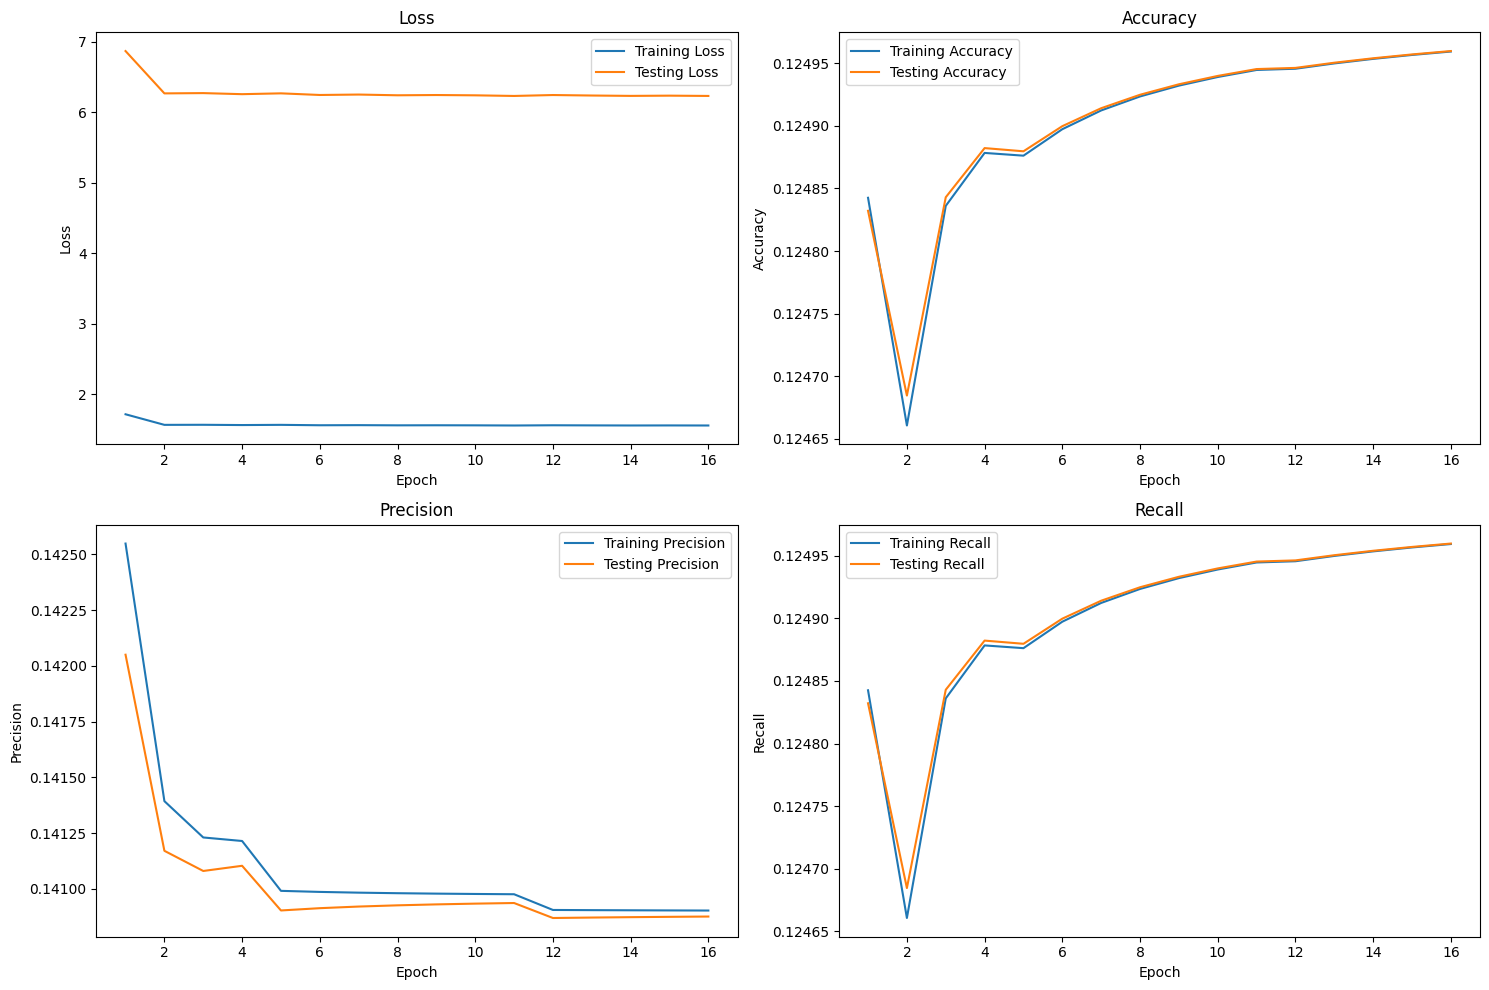

In [8]:
plot_metrics(train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls)

In [6]:
def compare_predictions(model, dataloader, device, class_names, num_samples=1):
    model.eval()
    with torch.no_grad():
        images, labels = next(iter(dataloader))
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for i in range(num_samples):
            expected_class = class_names[labels[i].item()]
            predicted_class = class_names[predicted[i].item()]
            print(f'Expected: {expected_class}, Predicted: {predicted_class}')

# Diccionario de mapeo de índices de clases a nombres de enfermedades
class_names = {
    0: 'Normal',
    1: 'Diabetes',
    2: 'Glaucoma',
    3: 'Cataratas',
    4: 'Degeneración macular asociada a la edad',
    5: 'Hipertensión',
    6: 'Miopía',
    7: 'Otras enfermedades o anormalidades'
}




In [11]:
compare_predictions(model, test_dataloader, device, class_names, num_samples=20)

Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Otras enfermedades o anormalidades, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Glaucoma, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Cataratas, Predicted: Normal


### VGGnet16 con feature extraction

In [7]:
torch.cuda.empty_cache() 
import torch
import torch.nn as nn
import torchvision.models as models

class VGGNetFeatureExtraction(nn.Module):
    def __init__(self, num_classes):
        super(VGGNetFeatureExtraction, self).__init__()
        vgg = models.vgg16(models.VGG16_Weights.DEFAULT)
        
        # Congelar todas las capas convolucionales
        for param in vgg.features.parameters():
            param.requires_grad = False
        
        # Extraer las capas convolucionales del VGG16
        self.features = vgg.features
        
        # Agregar una nueva capa completamente conectada para la clasificación
        self.classifier = nn.Sequential(
            nn.Linear(in_features=25088, out_features=4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(in_features=4096, out_features=num_classes),
        )
    
    def forward(self, x):
        x = self.features(x)  # Extracción de características
        x = torch.flatten(x, 1)  # Aplanar las características
        x = self.classifier(x)  # Clasificación
        return x

# Ejemplo de uso
num_classes = 10  # Número de clases en tu problema de clasificación
model = VGGNetFeatureExtraction(num_classes=num_classes)


/home/cristina/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [8]:
num_epochs = 100
learning_rate = 0.001
num_classes = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGGNetFeatureExtraction(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls = train_and_evaluate(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs, device, early_stopping=True, patience=5)

Training Epoch 1/100: 100%|████████████████| 160/160 [00:42<00:00,  3.78batch/s]


Training Loss: 1.7733, Training Accuracy: 0.2783, Training Precision: 0.2823, Training Recall: 0.2783


Testing Epoch 1/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.21batch/s]


Testing Loss: 7.0930, Testing Accuracy: 0.2853, Testing Precision: 0.2971, Testing Recall: 0.2853


Training Epoch 2/100: 100%|████████████████| 160/160 [00:40<00:00,  3.95batch/s]


Training Loss: 1.3958, Training Accuracy: 0.3093, Training Precision: 0.3526, Training Recall: 0.3093


Testing Epoch 2/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.45batch/s]


Testing Loss: 5.5831, Testing Accuracy: 0.3144, Testing Precision: 0.3586, Testing Recall: 0.3144


Training Epoch 3/100: 100%|████████████████| 160/160 [00:40<00:00,  3.96batch/s]


Training Loss: 1.3829, Training Accuracy: 0.3257, Training Precision: 0.3765, Training Recall: 0.3257


Testing Epoch 3/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.45batch/s]


Testing Loss: 5.5318, Testing Accuracy: 0.3274, Testing Precision: 0.3785, Testing Recall: 0.3274


Training Epoch 4/100: 100%|████████████████| 160/160 [00:40<00:00,  3.96batch/s]


Training Loss: 1.3025, Training Accuracy: 0.3403, Training Precision: 0.4084, Training Recall: 0.3403


Testing Epoch 4/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.43batch/s]


Testing Loss: 5.2101, Testing Accuracy: 0.3420, Testing Precision: 0.4083, Testing Recall: 0.3420


Training Epoch 5/100: 100%|████████████████| 160/160 [00:40<00:00,  3.95batch/s]


Training Loss: 1.2628, Training Accuracy: 0.3487, Training Precision: 0.4272, Training Recall: 0.3487


Testing Epoch 5/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 5.0510, Testing Accuracy: 0.3488, Testing Precision: 0.4285, Testing Recall: 0.3488


Training Epoch 6/100: 100%|████████████████| 160/160 [00:40<00:00,  3.96batch/s]


Training Loss: 1.2163, Training Accuracy: 0.3540, Training Precision: 0.4516, Training Recall: 0.3540


Testing Epoch 6/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.45batch/s]


Testing Loss: 4.8651, Testing Accuracy: 0.3536, Testing Precision: 0.4523, Testing Recall: 0.3536


Training Epoch 7/100: 100%|████████████████| 160/160 [00:40<00:00,  3.97batch/s]


Training Loss: 1.1747, Training Accuracy: 0.3587, Training Precision: 0.4684, Training Recall: 0.3587


Testing Epoch 7/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.48batch/s]


Testing Loss: 4.6987, Testing Accuracy: 0.3593, Testing Precision: 0.4675, Testing Recall: 0.3593


Training Epoch 8/100: 100%|████████████████| 160/160 [00:40<00:00,  3.95batch/s]


Training Loss: 1.1529, Training Accuracy: 0.3654, Training Precision: 0.4842, Training Recall: 0.3654


Testing Epoch 8/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 4.6118, Testing Accuracy: 0.3654, Testing Precision: 0.4845, Testing Recall: 0.3654


Training Epoch 9/100: 100%|████████████████| 160/160 [00:40<00:00,  3.95batch/s]


Training Loss: 1.1484, Training Accuracy: 0.3697, Training Precision: 0.4981, Training Recall: 0.3697


Testing Epoch 9/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 4.5937, Testing Accuracy: 0.3693, Testing Precision: 0.4987, Testing Recall: 0.3693


Training Epoch 10/100: 100%|███████████████| 160/160 [00:40<00:00,  3.93batch/s]


Training Loss: 1.0781, Training Accuracy: 0.3735, Training Precision: 0.5116, Training Recall: 0.3735


Testing Epoch 10/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 4.3124, Testing Accuracy: 0.3733, Testing Precision: 0.5115, Testing Recall: 0.3733


Training Epoch 11/100: 100%|███████████████| 160/160 [00:40<00:00,  3.91batch/s]


Training Loss: 1.0695, Training Accuracy: 0.3774, Training Precision: 0.5236, Training Recall: 0.3774


Testing Epoch 11/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.46batch/s]


Testing Loss: 4.2781, Testing Accuracy: 0.3765, Testing Precision: 0.5229, Testing Recall: 0.3765


Training Epoch 12/100: 100%|███████████████| 160/160 [00:40<00:00,  3.93batch/s]


Training Loss: 1.0403, Training Accuracy: 0.3806, Training Precision: 0.5325, Training Recall: 0.3806


Testing Epoch 12/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.46batch/s]


Testing Loss: 4.1614, Testing Accuracy: 0.3806, Testing Precision: 0.5317, Testing Recall: 0.3806


Training Epoch 13/100: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 0.9482, Training Accuracy: 0.3868, Training Precision: 0.5429, Training Recall: 0.3868


Testing Epoch 13/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.48batch/s]


Testing Loss: 3.7929, Testing Accuracy: 0.3864, Testing Precision: 0.5427, Testing Recall: 0.3864


Training Epoch 14/100: 100%|███████████████| 160/160 [00:40<00:00,  3.98batch/s]


Training Loss: 0.9495, Training Accuracy: 0.3914, Training Precision: 0.5531, Training Recall: 0.3914


Testing Epoch 14/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.56batch/s]


Testing Loss: 3.7979, Testing Accuracy: 0.3913, Testing Precision: 0.5524, Testing Recall: 0.3913


Training Epoch 15/100: 100%|███████████████| 160/160 [00:41<00:00,  3.88batch/s]


Training Loss: 0.9552, Training Accuracy: 0.3945, Training Precision: 0.5591, Training Recall: 0.3945


Testing Epoch 15/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 3.8208, Testing Accuracy: 0.3941, Testing Precision: 0.5591, Testing Recall: 0.3941


Training Epoch 16/100: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 1.0189, Training Accuracy: 0.3962, Training Precision: 0.5626, Training Recall: 0.3962


Testing Epoch 16/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.40batch/s]


Testing Loss: 4.0757, Testing Accuracy: 0.3955, Testing Precision: 0.5623, Testing Recall: 0.3955


Training Epoch 17/100: 100%|███████████████| 160/160 [00:40<00:00,  3.93batch/s]


Training Loss: 1.0099, Training Accuracy: 0.3980, Training Precision: 0.5670, Training Recall: 0.3980


Testing Epoch 17/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 4.0396, Testing Accuracy: 0.3976, Testing Precision: 0.5663, Testing Recall: 0.3976


Training Epoch 18/100: 100%|███████████████| 160/160 [00:40<00:00,  3.95batch/s]


Training Loss: 0.9479, Training Accuracy: 0.4006, Training Precision: 0.5704, Training Recall: 0.4006


Testing Epoch 18/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 3.7914, Testing Accuracy: 0.4001, Testing Precision: 0.5672, Testing Recall: 0.4001


Training Epoch 19/100: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 0.9205, Training Accuracy: 0.4028, Training Precision: 0.5724, Training Recall: 0.4028


Testing Epoch 19/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 3.6820, Testing Accuracy: 0.4022, Testing Precision: 0.5721, Testing Recall: 0.4022


Training Epoch 20/100: 100%|███████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.9165, Training Accuracy: 0.4044, Training Precision: 0.5776, Training Recall: 0.4044


Testing Epoch 20/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 3.6662, Testing Accuracy: 0.4042, Testing Precision: 0.5764, Testing Recall: 0.4042


Training Epoch 21/100: 100%|███████████████| 160/160 [00:40<00:00,  3.95batch/s]


Training Loss: 0.8855, Training Accuracy: 0.4084, Training Precision: 0.5832, Training Recall: 0.4084


Testing Epoch 21/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.41batch/s]


Testing Loss: 3.5421, Testing Accuracy: 0.4078, Testing Precision: 0.5828, Testing Recall: 0.4078


Training Epoch 22/100: 100%|███████████████| 160/160 [00:40<00:00,  3.93batch/s]


Training Loss: 0.8644, Training Accuracy: 0.4119, Training Precision: 0.5879, Training Recall: 0.4119


Testing Epoch 22/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 3.4577, Testing Accuracy: 0.4115, Testing Precision: 0.5872, Testing Recall: 0.4115


Training Epoch 23/100: 100%|███████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.8807, Training Accuracy: 0.4147, Training Precision: 0.5924, Training Recall: 0.4147


Testing Epoch 23/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.37batch/s]


Testing Loss: 3.5229, Testing Accuracy: 0.4145, Testing Precision: 0.5913, Testing Recall: 0.4145


Training Epoch 24/100: 100%|███████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.8614, Training Accuracy: 0.4184, Training Precision: 0.5969, Training Recall: 0.4184


Testing Epoch 24/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 3.4456, Testing Accuracy: 0.4178, Testing Precision: 0.5961, Testing Recall: 0.4178


Training Epoch 25/100: 100%|███████████████| 160/160 [00:41<00:00,  3.89batch/s]


Training Loss: 0.8574, Training Accuracy: 0.4208, Training Precision: 0.6010, Training Recall: 0.4208


Testing Epoch 25/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 3.4296, Testing Accuracy: 0.4204, Testing Precision: 0.6004, Testing Recall: 0.4204


Training Epoch 26/100: 100%|███████████████| 160/160 [00:40<00:00,  3.96batch/s]


Training Loss: 0.8009, Training Accuracy: 0.4244, Training Precision: 0.6065, Training Recall: 0.4244


Testing Epoch 26/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.48batch/s]


Testing Loss: 3.2035, Testing Accuracy: 0.4243, Testing Precision: 0.6054, Testing Recall: 0.4243


Training Epoch 27/100: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 0.8329, Training Accuracy: 0.4280, Training Precision: 0.6109, Training Recall: 0.4280


Testing Epoch 27/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.38batch/s]


Testing Loss: 3.3317, Testing Accuracy: 0.4277, Testing Precision: 0.6096, Testing Recall: 0.4277


Training Epoch 28/100: 100%|███████████████| 160/160 [00:40<00:00,  3.91batch/s]


Training Loss: 0.8508, Training Accuracy: 0.4308, Training Precision: 0.6147, Training Recall: 0.4308


Testing Epoch 28/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.45batch/s]


Testing Loss: 3.4033, Testing Accuracy: 0.4305, Testing Precision: 0.6139, Testing Recall: 0.4305


Training Epoch 29/100: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 0.7778, Training Accuracy: 0.4346, Training Precision: 0.6200, Training Recall: 0.4346


Testing Epoch 29/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 3.1112, Testing Accuracy: 0.4341, Testing Precision: 0.6193, Testing Recall: 0.4341


Training Epoch 30/100: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 0.8092, Training Accuracy: 0.4375, Training Precision: 0.6244, Training Recall: 0.4375


Testing Epoch 30/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.40batch/s]


Testing Loss: 3.2368, Testing Accuracy: 0.4370, Testing Precision: 0.6239, Testing Recall: 0.4370


Training Epoch 31/100: 100%|███████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.7771, Training Accuracy: 0.4407, Training Precision: 0.6297, Training Recall: 0.4407


Testing Epoch 31/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.41batch/s]


Testing Loss: 3.1083, Testing Accuracy: 0.4403, Testing Precision: 0.6290, Testing Recall: 0.4403


Training Epoch 32/100: 100%|███████████████| 160/160 [00:40<00:00,  3.93batch/s]


Training Loss: 0.8475, Training Accuracy: 0.4426, Training Precision: 0.6329, Training Recall: 0.4426


Testing Epoch 32/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.40batch/s]


Testing Loss: 3.3901, Testing Accuracy: 0.4421, Testing Precision: 0.6323, Testing Recall: 0.4421


Training Epoch 33/100: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 0.7921, Training Accuracy: 0.4451, Training Precision: 0.6370, Training Recall: 0.4451


Testing Epoch 33/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.48batch/s]


Testing Loss: 3.1686, Testing Accuracy: 0.4448, Testing Precision: 0.6363, Testing Recall: 0.4448


Training Epoch 34/100: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 0.8031, Training Accuracy: 0.4477, Training Precision: 0.6398, Training Recall: 0.4477


Testing Epoch 34/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.49batch/s]


Testing Loss: 3.2125, Testing Accuracy: 0.4472, Testing Precision: 0.6395, Testing Recall: 0.4472


Training Epoch 35/100: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 0.8277, Training Accuracy: 0.4493, Training Precision: 0.6437, Training Recall: 0.4493


Testing Epoch 35/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.49batch/s]


Testing Loss: 3.3109, Testing Accuracy: 0.4488, Testing Precision: 0.6434, Testing Recall: 0.4488


Training Epoch 36/100: 100%|███████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.7585, Training Accuracy: 0.4519, Training Precision: 0.6456, Training Recall: 0.4519


Testing Epoch 36/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.48batch/s]


Testing Loss: 3.0341, Testing Accuracy: 0.4515, Testing Precision: 0.6452, Testing Recall: 0.4515


Training Epoch 37/100: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 0.7632, Training Accuracy: 0.4541, Training Precision: 0.6491, Training Recall: 0.4541


Testing Epoch 37/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.45batch/s]


Testing Loss: 3.0530, Testing Accuracy: 0.4539, Testing Precision: 0.6486, Testing Recall: 0.4539


Training Epoch 38/100: 100%|███████████████| 160/160 [00:40<00:00,  3.95batch/s]


Training Loss: 0.8036, Training Accuracy: 0.4561, Training Precision: 0.6520, Training Recall: 0.4561


Testing Epoch 38/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 3.2144, Testing Accuracy: 0.4558, Testing Precision: 0.6516, Testing Recall: 0.4558


Training Epoch 39/100: 100%|███████████████| 160/160 [00:40<00:00,  3.93batch/s]


Training Loss: 0.7735, Training Accuracy: 0.4581, Training Precision: 0.6547, Training Recall: 0.4581


Testing Epoch 39/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.40batch/s]


Testing Loss: 3.0942, Testing Accuracy: 0.4577, Testing Precision: 0.6543, Testing Recall: 0.4577


Training Epoch 40/100: 100%|███████████████| 160/160 [00:40<00:00,  3.91batch/s]


Training Loss: 0.8003, Training Accuracy: 0.4598, Training Precision: 0.6578, Training Recall: 0.4598


Testing Epoch 40/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.46batch/s]


Testing Loss: 3.2011, Testing Accuracy: 0.4593, Testing Precision: 0.6574, Testing Recall: 0.4593


Training Epoch 41/100: 100%|███████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.8137, Training Accuracy: 0.4602, Training Precision: 0.6595, Training Recall: 0.4602


Testing Epoch 41/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.34batch/s]

Testing Loss: 3.2547, Testing Accuracy: 0.4597, Testing Precision: 0.6589, Testing Recall: 0.4597
No improvement for 5 epochs. Early stopping...


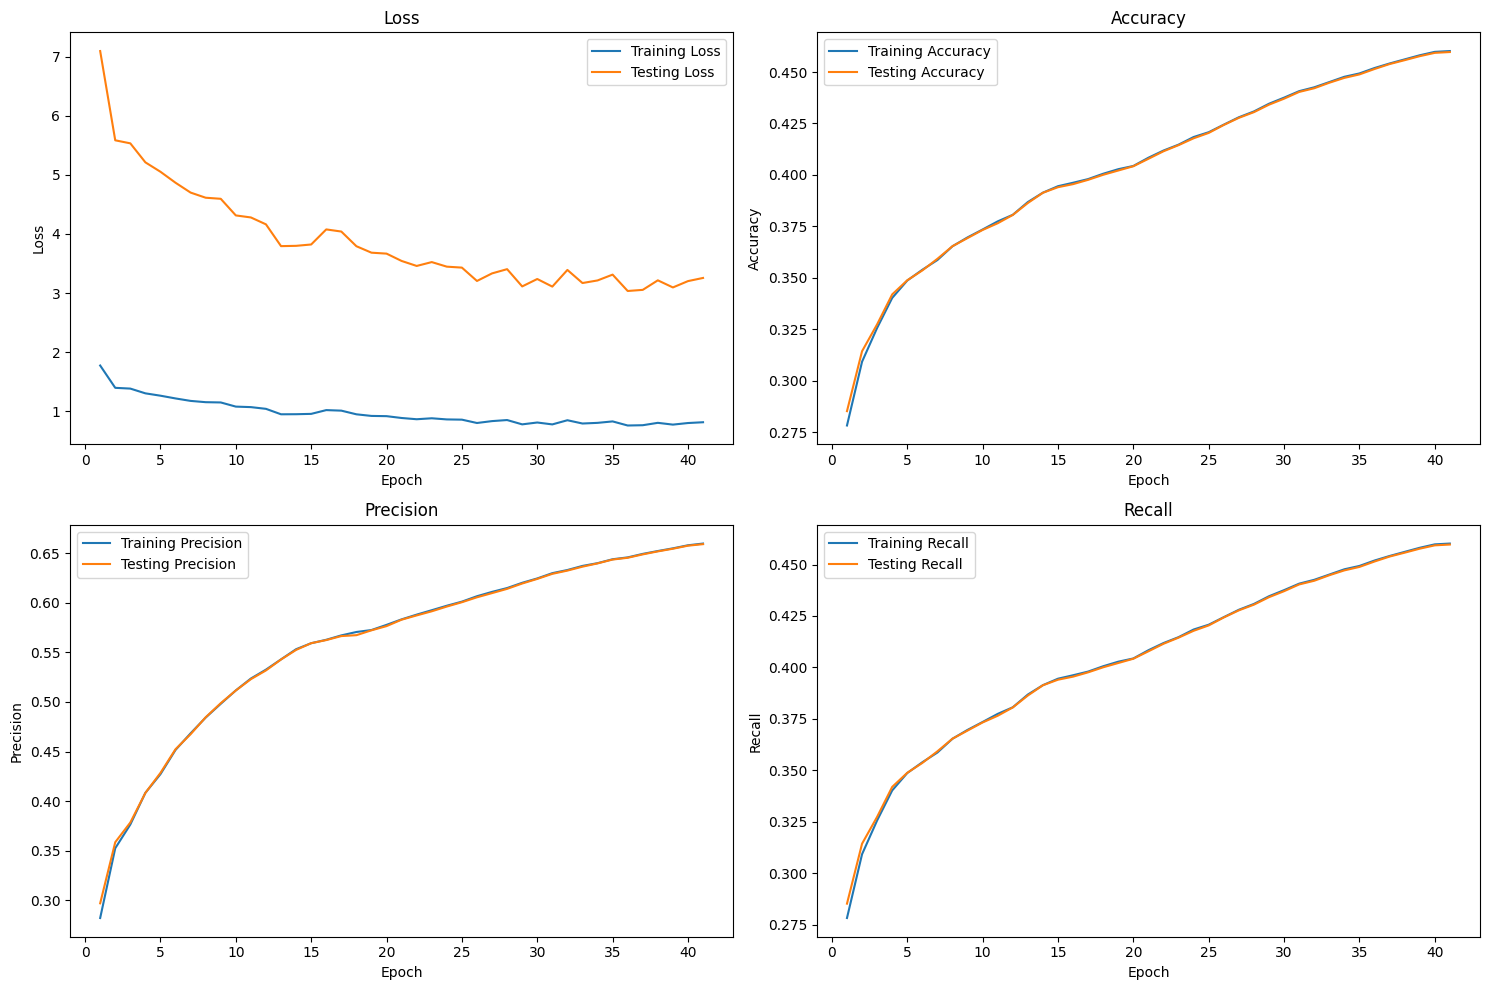

In [9]:
plot_metrics(train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls)

In [10]:
compare_predictions(model, test_dataloader, device, class_names, num_samples=20)

Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Miopía, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Diabetes
Expected: Normal, Predicted: Normal
Expected: Cataratas, Predicted: Cataratas
Expected: Hipertensión, Predicted: Diabetes
Expected: Diabetes, Predicted: Normal
Expected: Miopía, Predicted: Miopía
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Normal, Predicted: Diabetes
Expected: Normal, Predicted: Diabetes
Expected: Diabetes, Predicted: Hipertensión
